In [1]:
import numpy as np
np.random.seed(10)
import tensorflow as tf
tf.random.set_seed(10)
import matplotlib.pyplot as plt
tf.keras.backend.set_floatx('float64')

# Load MNIST data set
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(-1,28*28)/255
test_images = test_images.reshape(-1,28*28)/255

np.random.shuffle(train_images)

In [2]:
class vi_nf_model(tf.keras.Model):
    def __init__(self,num_latent,num_flow_iters):
        super(vi_nf_model,self).__init__()
        
        # Constants
        self.num_latent = num_latent
        self.num_flow_iters = num_flow_iters
                
        # Initializer
        xavier = tf.keras.initializers.GlorotUniform()
        
        # Define inference architecture
        self.l1 = tf.keras.layers.Dense(150,activation='swish')
        self.l2 = tf.keras.layers.Dense(100,activation='swish')
        self.l3 = tf.keras.layers.Dense(50,activation='swish')
        
        # Variational stuff
        self.zz_mu = tf.keras.layers.Dense(num_latent,activation='swish')
        self.zz_logvar = tf.keras.layers.Dense(num_latent,activation='swish')
        
        # Normalizing flow stuff
        self.ww_list = []
        self.uu_list = []
        self.bb_list = []
        for _ in range(num_flow_iters):
            self.ww_list.append(xavier(shape=(num_latent,1),dtype='float64'))
            self.uu_list.append(xavier(shape=(num_latent,1),dtype='float64'))
            self.bb_list.append(xavier(shape=(1,),dtype='float64'))
            
        
        # Define reconstruction architecture
        self.l5 = tf.keras.layers.Dense(50,activation='swish')
        self.l6 = tf.keras.layers.Dense(100,activation='swish')
        self.l7 = tf.keras.layers.Dense(150,activation='swish')
        self.l8 = tf.keras.layers.Dense(28*28,activation='sigmoid')
        
        # Optimizer
        self.train_op = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.bce = tf.keras.losses.BinaryCrossentropy()

        
    def call(self,X):
        # Call inference
        h1 = self.l1(X)
        h2 = self.l2(h1)
        h3 = self.l3(h2)
               
        # Latent space quantities
        self.mu = self.zz_mu(h3)
        self.logvar = self.zz_logvar(h3)
        
        # Shapes
        batch_size = tf.shape(self.mu)[0]
        nl = self.num_latent
        
        # Batch wise latent space operations
        eps = tf.random.normal(shape=(batch_size,nl),mean=0.0,stddev=1.0,dtype='float64')
        self.Z = self.mu + tf.math.exp(0.5*self.logvar)*eps
        
        # Find density value of initial sample 
        self.logZ0 = -0.5*(tf.cast(tf.math.log(2.0*np.pi),dtype='float64') - self.logvar) - (0.5*(self.Z-self.mu)**2)/(2.0*tf.exp(self.logvar))
        
        # Use normalizing flow and get energy (needed for loss function)
        self.Zk, flow_energy = self.normalizing_flow(self.Z,self.logZ0)
                
        # Decode
        h5 = self.l5(self.Zk)
        h6 = self.l6(h5)
        h7 = self.l7(h6)
        out = self.l8(h7)
        
        return out, flow_energy

        
    def normalizing_flow(self,Z,logstart):
        
        # Number of transformations
        Kval = self.num_flow_iters
        zprev = Z
        
        for i in range(Kval):
            w_i = self.ww_list[i]
            u_i = self.uu_list[i]
            b_i = self.bb_list[i]
            
            wz = tf.matmul(zprev,w_i)
            
            tt = tf.math.tanh(wz+b_i)
            dtt = 1.0-(tf.math.tanh(wz+b_i))**2
            
            zprev = zprev + tf.matmul(tt,tf.transpose(u_i))
            phi = tf.matmul(tt,tf.transpose(w_i))
            
            utphi = tf.matmul(phi,u_i)
            
            logstart = logstart - tf.math.log(tf.math.abs(1.0+utphi))
        
        return zprev, logstart

    def sample_latent(self,X,num_samples):
        sample_list = []
        for sample in range(num_samples):
            sample_list.append(self.call(X)[0].numpy())

        return sample_list
    
    def get_loss(self,X):
        Ypred, flow_energy = self.call(X)        
        return self.bce(X,Ypred) + tf.reduce_mean(flow_energy)

    def get_grad(self,X):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            L = self.get_loss(X)
            g = tape.gradient(L, self.trainable_variables)
        return g
    
    # perform gradient descent - regular
    def network_learn(self,X):
        g = self.get_grad(X)
        self.train_op.apply_gradients(zip(g, self.trainable_variables))
        
    # Train the model
    def train_model(self,Xtrain):
        plot_iter = 0
        stop_iter = 0
        patience = 10
        best_loss = 999999.0 # Some large number 

        self.num_batches = 10
        self.train_batch_size = int(Xtrain.shape[0]/self.num_batches)
        
        for i in range(200):
            # Training loss
            print('Training iteration:',i)
            
            loss = 0.0
            for batch in range(self.num_batches):
                input_batch = Xtrain[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                self.network_learn(input_batch)
                batch_loss = self.get_loss(input_batch).numpy()
                loss+=batch_loss
                print('Batch loss:',batch_loss)
            
            loss = loss/self.num_batches
            print('Epoch loss:',loss)

            # Check early stopping criteria
            if loss < best_loss:
                
                print('Improved loss from:',best_loss,' to:', loss)                
                best_loss = loss
                self.save_weights('./checkpoints/my_checkpoint')
                
                stop_iter = 0
            else:
                print('Loss (no improvement):',loss)
                stop_iter = stop_iter + 1

            if stop_iter == patience:
                break
        
    def test_model(self,Xtest):
        # Check accuracy on test
        print('Test loss:',self.get_loss(Xtest).numpy())

    # Load weights
    def restore_model(self):
        self.load_weights('./checkpoints/my_checkpoint') # Load pretrained model

In [3]:
model = vi_nf_model(40,10)

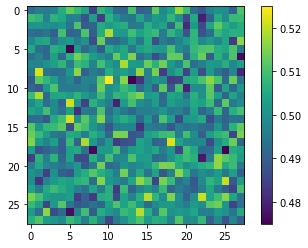

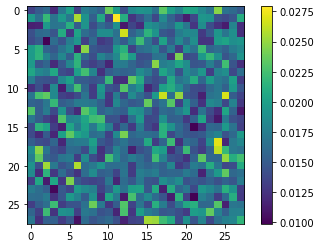

In [15]:
# Sample before training
sample = 1000
num_samples = 100
sample_list = np.asarray(model.sample_latent(train_images[sample:sample+1],num_samples))[:,0,:]
plt.figure()
plt.imshow(np.mean(sample_list,axis=0).reshape(28,28))
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.std(sample_list,axis=0).reshape(28,28))
plt.colorbar()
plt.show()

In [16]:
model.train_model(train_images)

Training iteration: 0
Batch loss: -0.24299609341655037
Batch loss: -0.31510167951397317
Batch loss: -0.40398164610395515
Batch loss: -0.5013946757483261
Batch loss: -0.6192260914133552
Batch loss: -0.7467954719056793
Batch loss: -0.8940160083386002
Batch loss: -1.0575736087465266
Batch loss: -1.1892335292621783
Batch loss: -1.3195000938850348
Epoch loss: -0.7289818898334179
Improved loss from: 999999.0  to: -0.7289818898334179
Training iteration: 1
Batch loss: -1.469580927017677
Batch loss: -1.6318298597522234
Batch loss: -1.7993445542611695
Batch loss: -1.9764002144282684
Batch loss: -2.178517294588556
Batch loss: -2.369403936582415
Batch loss: -2.610283927114987
Batch loss: -2.7870485634411306
Batch loss: -2.951976220167842
Batch loss: -3.084338070116977
Epoch loss: -2.2858723567471246
Improved loss from: -0.7289818898334179  to: -2.2858723567471246
Training iteration: 2
Batch loss: -3.178971627161352
Batch loss: -3.273282111941058
Batch loss: -3.3480521573718582
Batch loss: -3.42595

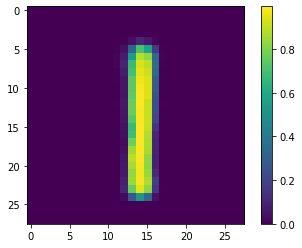

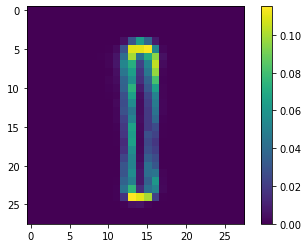

In [17]:
# Sample after training
sample = 1000
num_samples = 100
sample_list = np.asarray(model.sample_latent(train_images[sample:sample+1],num_samples))[:,0,:]
plt.figure()
plt.imshow(np.mean(sample_list,axis=0).reshape(28,28))
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.std(sample_list,axis=0).reshape(28,28))
plt.colorbar()
plt.show()

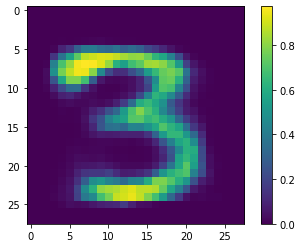

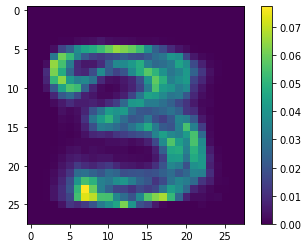

In [20]:
# Sample after training
sample = 0
num_samples = 100
sample_list = np.asarray(model.sample_latent(train_images[sample:sample+1],num_samples))[:,0,:]
plt.figure()
plt.imshow(np.mean(sample_list,axis=0).reshape(28,28))
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.std(sample_list,axis=0).reshape(28,28))
plt.colorbar()
plt.show()

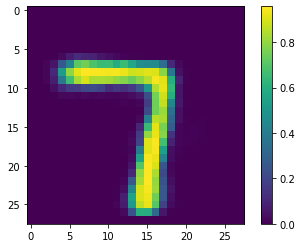

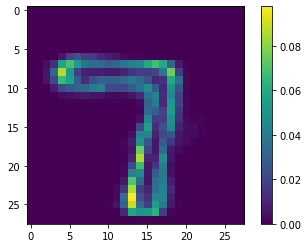

In [22]:
# Sample after training
sample = 50
num_samples = 100
sample_list = np.asarray(model.sample_latent(train_images[sample:sample+1],num_samples))[:,0,:]
plt.figure()
plt.imshow(np.mean(sample_list,axis=0).reshape(28,28))
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.std(sample_list,axis=0).reshape(28,28))
plt.colorbar()
plt.show()